In [1]:
import plotly.express as px
import numpy as np
import nibabel as nib
from PIL import Image, ImageSequence
import matplotlib.pyplot as plt
import os
import pandas as pd
import pickle
from glob import glob
import argparse

import sys
sys.path.append('../../modified_medsam_repo')
from MedSAM_HCP.dataset import MRIDataset, load_datasets
from MedSAM_HCP.MedSAM import MedSAM, medsam_inference
from MedSAM_HCP.build_sam import build_sam_vit_b_multiclass
from MedSAM_HCP.utils_hcp import *


In [18]:
dicto = {
    'Brats_MedSAM': '/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/brats_segmentations_10-17-24/region_animations/001/medsam/fused.gif',
    'RegisteredBrats_MedSAM': '/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/registered_brats_normalized_expt_10-29-24/region_animations/brats_001_registered/singletask_unprompted/fused.gif',
    'Brats_UNet': '/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/brats_segmentations_10-17-24/region_animations/001/unet/fused.gif',
    'RegisteredBrats_UNet': '/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/registered_brats_normalized_expt_10-29-24/region_animations/brats_001_registered/singletask_unet/fused.gif',
    'RegisteredBrats_Rescale135_UNet': '/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/registered_brats_normalized_expt_rescale135_10-29-24/region_animations/brats_001_registered/singletask_unet/fused.gif',
    'RegisteredBrats_Rescale135_MedSAM': '/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/registered_brats_normalized_expt_rescale135_10-29-24/region_animations/brats_001_registered/singletask_unprompted/fused.gif'
}

img_dicto = {
    'RegisteredBrats_UNet': '/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/registered_brats_normalized_expt_10-29-24/inputs/pngs/brats_001_registered/brats_001_registered_slice',
    'RegisteredBrats_Rescale135_UNet': '/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/registered_brats_normalized_expt_rescale135_10-29-24/inputs/pngs/brats_001_registered/brats_001_registered_slice'
}

In [2]:
def open_gif(path, label_converter = None, specific_slice = None, specific_label = None):
    arr_list = []
    if not os.path.exists(path):
        # treat as pattern
        listo = glob(path)
        assert len(listo)==1
        path = listo[0]

    if path.endswith('.gif'):
        with Image.open(path) as im:
            for i, frame in enumerate(ImageSequence.Iterator(im)):
                if i == 0:
                    continue
                arr_list.append(np.array(frame).reshape((1,256,256,3)))
        arr = np.concatenate(arr_list, axis=0)
    elif path.endswith('.npy'):
        arr = np.load(path).astype(int)
        if arr.shape == (256,256):
            arr = np.vectorize(label_converter.hcp_to_compressed)(arr)
        elif arr.shape == (256,256,256):
            arr = arr[specific_slice,:,:]

        if specific_label is not None:
            arr = arr == specific_label

        arr = np.repeat(arr[:,:,None], 3, axis=2)
        

    return arr.astype(int)

def generate_plot(dict_obj, labels = [], slices = [], do_offset = [], factor=0.8, include_title=False, titles=[], figure = None, pass_single_slice = False, label_converter = None):
    if figure is None:
        fig, axs = plt.subplots(len(slices), len(labels), figsize=(3.3/2*len(labels), 18 / 10 * len(slices)), squeeze=False)
    else:
        axs = figure.subplots(len(slices), len(labels), squeeze=False)
        fig = figure

    for i, label in enumerate(labels):
        path = dict_obj[label]
        
        for j in range(len(slices)):
            arr = open_gif(path, label_converter = label_converter, specific_slice = slices[j])
            if do_offset[i]:
                # middle maps to middle
                # (slices[j] - 128)
                # if want x < middle -> int((middle - x) * 0.8) + middle
                #middle = arr.shape[0] // 2
                #new_slice = middle + int( (slices[j] - middle) * factor)
                new_slice = int(slices[j] * factor)
                chooso = arr[new_slice, :, :, :] # 256 256 3
                chooso = np.rot90(chooso)
                axs[j, i].imshow(chooso)
            else:
                if pass_single_slice:
                    chooso = arr
                else:
                    chooso = arr[slices[j], :, :, :]
                chooso = np.rot90(chooso)
                axs[j, i].imshow(chooso)
            axs[j, i].set_xticks([])
            axs[j, i].set_yticks([])
            if include_title:
                axs[j,i].set_title(titles[i])
    if figure is None:
        fig.tight_layout()
    return fig



In [13]:
num = 10
slices = np.linspace(0, arr.shape[0], num = num + 2, dtype=int)
slices = slices[1:-1]
fig =generate_plot(dicto, labels = ['Brats_MedSAM', 'RegisteredBrats_MedSAM',
    'Brats_UNet', 'RegisteredBrats_UNet'],
    slices = slices, do_offset = [True, False, True, False], factor = .9375)

#fig.savefig('/gpfs/home/kn2347/figs/brats_vs_registeredbrats_medsam_unet.pdf', dpi = 300)
#arr = open_gif(dicto['Brats_UNet'])

NameError: name 'arr' is not defined

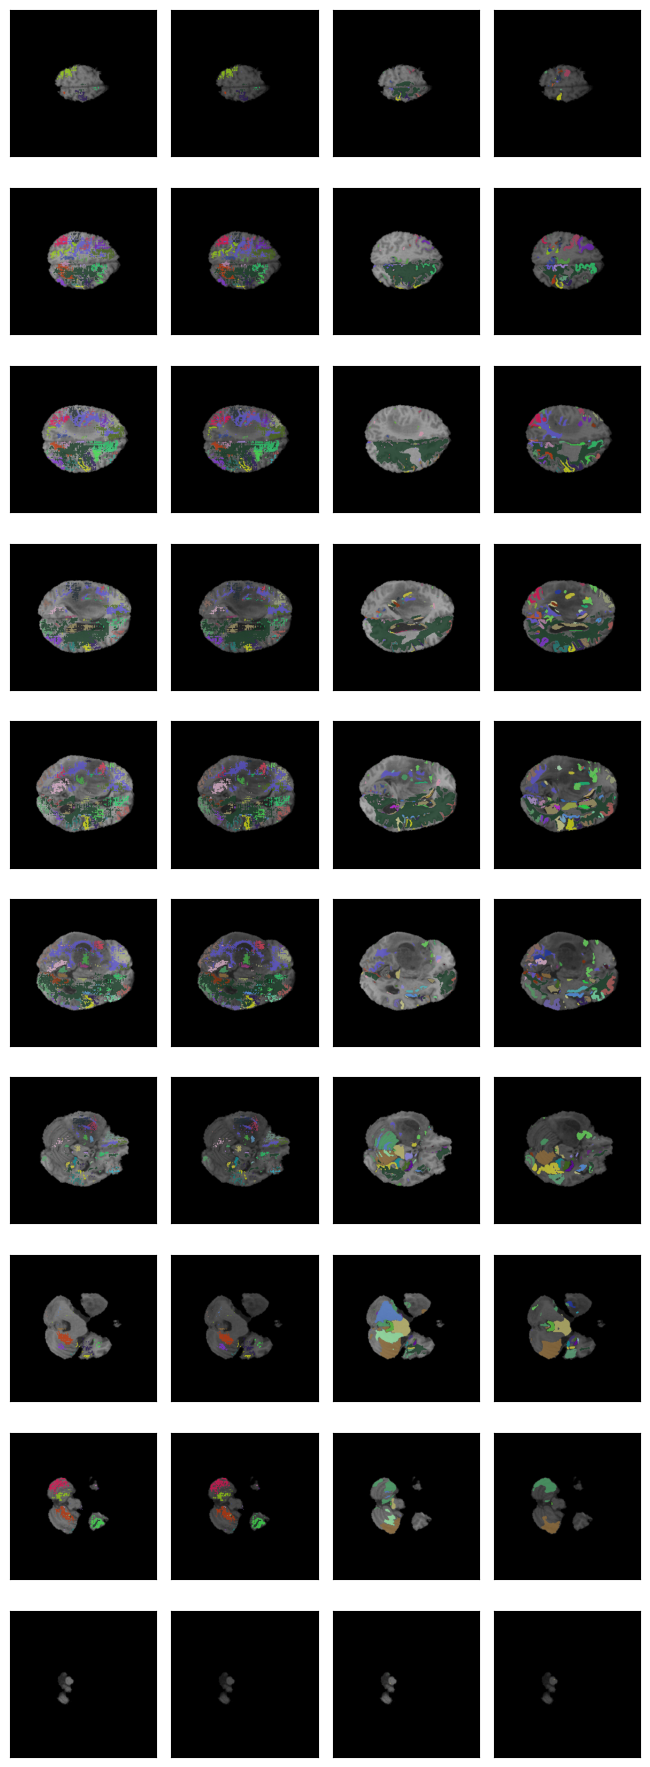

In [21]:
num = 10
slices = np.linspace(0, 152, num = num + 2, dtype=int)
slices = slices[1:-1]
fig =generate_plot(dicto, labels = ['RegisteredBrats_MedSAM', 'RegisteredBrats_Rescale135_MedSAM', 'RegisteredBrats_UNet', 'RegisteredBrats_Rescale135_UNet'],
    slices = slices, do_offset = [False, False, False, False], factor = .9375)
fig.savefig('/gpfs/home/kn2347/figs/registeredbrats_rescale135_medsam_unet.pdf', dpi = 300)

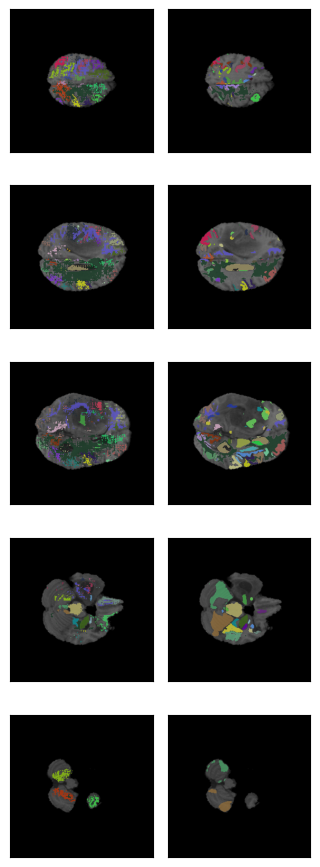

In [22]:
num = 5
slices = np.linspace(0, 152, num = num + 2, dtype=int)
slices = slices[1:-1]
fig =generate_plot(dicto, labels = ['RegisteredBrats_Rescale135_MedSAM', 'RegisteredBrats_Rescale135_UNet'],
    slices = slices, do_offset = [False, False, False, False], factor = .9375)
fig.savefig('/gpfs/home/kn2347/figs/registeredbrats_rescale135_medsam_vs_unet.pdf', dpi = 300)

### Subset analysis tables

In [3]:
subset_dict_gif_paths = {}
for model_type in ['singletask_unet', 'singletask_unprompted']:
    for label in [1,5,18,58]:
        for frac in [0.1, 0.5, 1, 2.5, 5, 10, 25, 50, 75, 100]:
            subset_dict_gif_paths[f'{model_type}_{label}_{frac}'] = f'/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/subset_expt_gif_visualizations_10-30-24/region_animations/151425/{model_type}/{label}/{frac}/*.gif'

            subset_dict_gif_paths[f'pure_seg_{model_type}_{label}_{frac}'] = f'/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/subset_expt_gif_visualizations_10-30-24/segmentations/{model_type}/{label}/{frac}/151425/singletask_seg_all.npy'


# add
subset_dict_gif_paths['groundtruth'] = '/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/segmentation_slices/151425/seg_101.npy'
#subset_dict_gif_paths['groundtruth'] = '/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/segmentation_slices/151425/seg_101.npy'

In [12]:
def get_slice_that_maximizes_distance(dict_obj, labels):
    listo = []
    for i, label in enumerate(labels):
        path = dict_obj[label]
        arr = open_gif(path) # slice, 256, 256, 3
        arr = arr[None, :, :, :, :].astype(int)
        listo.append(arr)
    combined_arr = np.concatenate(listo, axis = 0)
    best = (-1, 0, [])
    for sli in range(combined_arr.shape[1]):
        opt = 0
        dists = []
        for i in range(len(labels)-1):
            term = combined_arr[i+1,sli,:,:,:] - combined_arr[i, sli, :, :, :] # distance between this frac and the next
            term = (term != 0).mean() # term is now the percent of pixels which do not match
            #term = np.sqrt(term)
            opt += term
            dists.append(term)
        opt = np.min(dists)
        if opt > best[1]:
            best = (sli, opt, dists)
    
    return best
            
def plot_difference_maps(dict_obj, labels = [], slices = [], figure=None):
    if figure is None:
        fig, axs = plt.subplots(len(slices), len(labels), figsize=(3.3/2*len(labels), 18 / 10 * len(slices)), squeeze=False)
    else:
        axs = figure.subplots(len(slices), len(labels), squeeze=False)
        fig = figure

    listo = []
    for i, label in enumerate(labels):
        path = dict_obj[label]
        arr = open_gif(path) # slice, 256, 256, 3
        arr = arr[None, :, :, :, :].astype(int)
        listo.append(arr)
    combined_arr = np.concatenate(listo, axis = 0)

    for i, label in enumerate(labels):
        for j in range(len(slices)):
            if i==0:
                axs[j,i].imshow(np.full((256,256,3), 255))
            else:
                diff = combined_arr[i, slices[j], :, :, :] - combined_arr[i-1, slices[j], :, :, :] # get difference with previous
                diff_mag = np.sign(diff[:,:,0]) # (256,256)
                diff_mag = np.rot90(diff_mag)
                axs[j,i].imshow(diff_mag, cmap='bwr_r', vmin=-1, vmax=1)

            axs[j, i].set_xticks([])
            axs[j, i].set_yticks([])
    if figure is None:
        fig.tight_layout()
    return fig

def plot_difference_maps_pairwise(dict_obj, labels = [], slices = [], figure=None, pass_single_slice1 = False, pass_single_slice2 = False, label_converter = None, specific_label = None):
    # labels now contains tuples (L1, L2), and each map should represent L1 - L2

    if figure is None:
        fig, axs = plt.subplots(len(slices), len(labels), figsize=(3.3/2*len(labels), 18 / 10 * len(slices)), squeeze=False)
    else:
        axs = figure.subplots(len(slices), len(labels), squeeze=False)
        fig = figure

    for i in range(len(labels)):
        L1 = labels[i][0]
        L2 = labels[i][1]
        # we are interested in map(L1) - map(L2)

        

        for j in range(len(slices)):
            arr1 = open_gif(dict_obj[L1], label_converter = label_converter, specific_slice = slices[j], specific_label = specific_label)
            arr2 = open_gif(dict_obj[L2], label_converter = label_converter, specific_slice = slices[j], specific_label = specific_label)
            chooso1 = arr1 if pass_single_slice1 else arr1[slices[j], :, :, :]
            chooso2 = arr2 if pass_single_slice2 else arr2[slices[j], :, :, :]

            diff = chooso1 - chooso2 # this is (256,256,3)
            diff_mag = np.sign(diff[:,:,0]) # (256,256)
            # fix rotation before plotting
            diff_mag = np.rot90(diff_mag)
            axs[j,i].imshow(diff_mag, cmap='bwr_r', vmin=-1, vmax=1)

            axs[j, i].set_xticks([])
            axs[j, i].set_yticks([])
    if figure is None:
        fig.tight_layout()
    return fig



In [8]:
opt_slices = {}
model_type = 'singletask_unet'
for label in [1,5,18,58]:
    xx = []
    for frac in [0.1, 0.5, 1, 2.5, 5, 10, 25, 50, 75, 100]:
        xx.append(f'{model_type}_{label}_{frac}')
    zy = get_slice_that_maximizes_distance(subset_dict_gif_paths, xx)
    opt_slices[label] = zy[0]
    print(f'For label {label}: Optimal slice to view differences is {zy[0]}')

For label 1: Optimal slice to view differences is 101
For label 5: Optimal slice to view differences is 119
For label 18: Optimal slice to view differences is 108
For label 58: Optimal slice to view differences is 103


-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1
-1 1


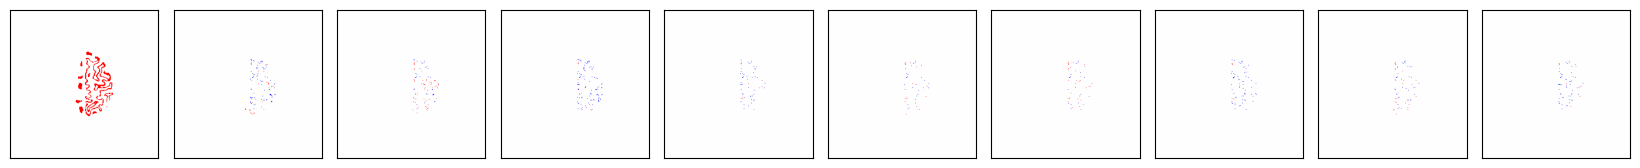

In [10]:
# difference maps but now with ground truth
df_hcp = pd.read_csv('/gpfs/home/kn2347/HCP_MedSAM_project/modified_medsam_repo/hcp_mapping_processed.csv')
df_desired = pd.read_csv('/gpfs/home/kn2347/HCP_MedSAM_project/modified_medsam_repo/darts_name_class_mapping_processed.csv')
NUM_CLASSES = len(df_desired)
label_converter = LabelConverter(df_hcp, df_desired)


for label in [1]:
    labels = []
    for frac in [0.1, 0.5, 1, 2.5, 5, 10, 25, 50, 75, 100]:
        labels.append((f'groundtruth', f'pure_seg_singletask_unet_{label}_{frac}'))
    fig = plot_difference_maps_pairwise(subset_dict_gif_paths, labels = labels, slices = [opt_slices[label]], figure=None, pass_single_slice1=True, pass_single_slice2=True, label_converter = label_converter, specific_label = label)
    #fig.savefig(f'/gpfs/home/kn2347/figs/subset_analysis_plot_examples_unet_medsam/unet-medsam/unet-medsam_{label}.pdf', dpi=300)
    #fig.savefig(f'/gpfs/home/kn2347/figs/subset_analysis_plot_examples_unet_medsam/unet-medsam/gt-unet_{label}.pdf', dpi=300)


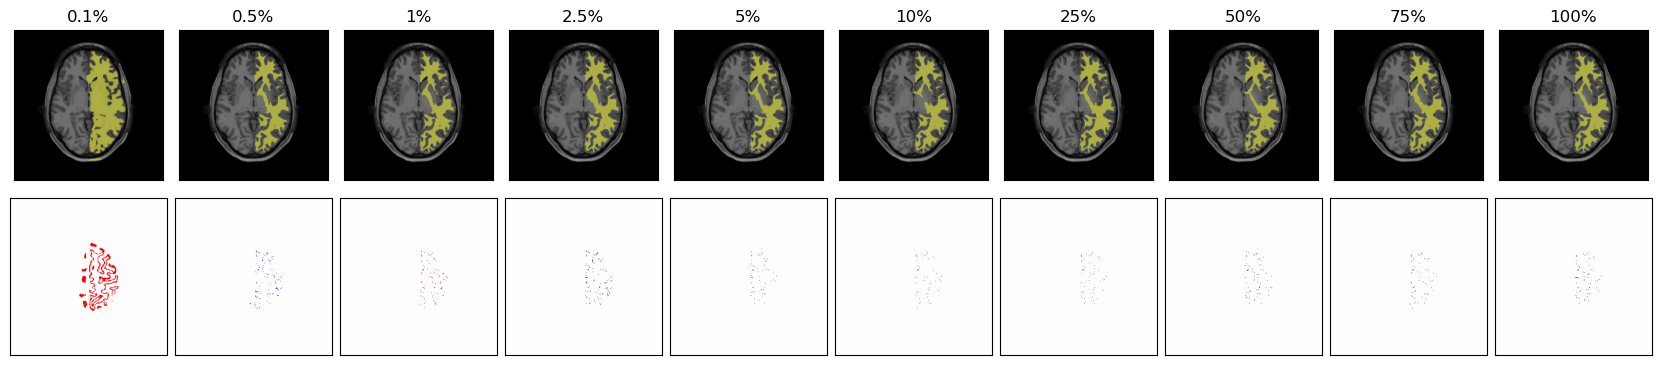

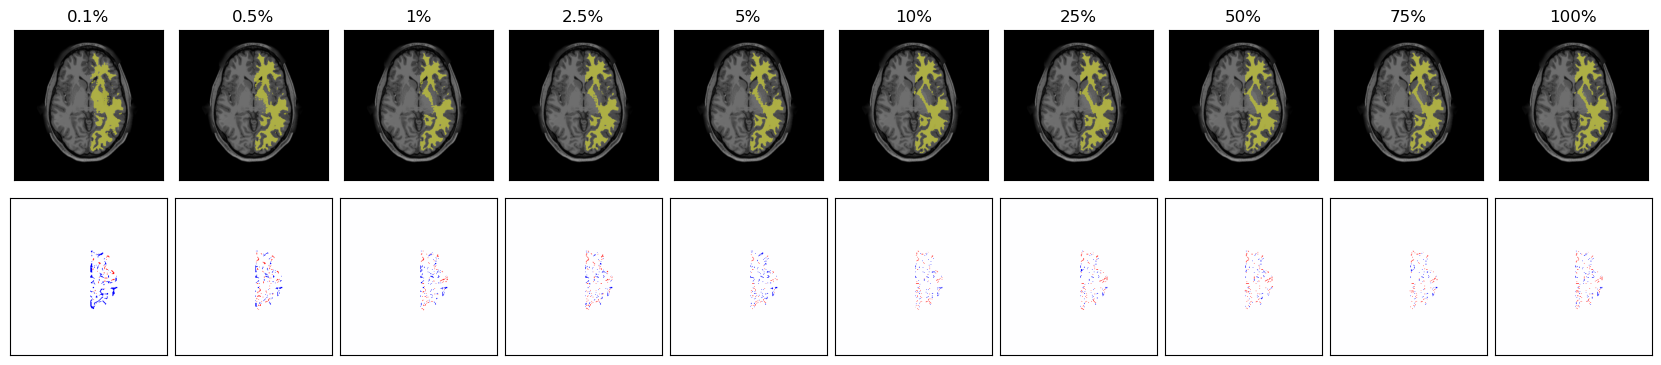

In [14]:
for label in [1]:
    for model_type in ['singletask_unet', 'singletask_unprompted']:
        xx = []
        labels = []
        for frac in [0.1, 0.5, 1, 2.5, 5, 10, 25, 50, 75, 100]:
            xx.append(f'{model_type}_{label}_{frac}')
            labels.append((f'groundtruth', f'pure_seg_{model_type}_{label}_{frac}'))

        slices = [opt_slices[label]]


        total_fig = plt.figure(constrained_layout=True, figsize=(3.3/2*10, 18/10*2))
        subfigs = total_fig.subfigures(2, 1, hspace=0.02)


        generate_plot(subset_dict_gif_paths, labels = xx,
            slices = slices, do_offset = [False] * len(xx), 
            include_title=True, titles = ['0.1%', '0.5%', '1%', '2.5%', '5%', '10%', '25%', '50%', '75%', '100%'],
            figure = subfigs[0])

        plot_difference_maps_pairwise(subset_dict_gif_paths, labels = labels, slices = [opt_slices[label]], figure=subfigs[1], pass_single_slice1=True, pass_single_slice2=True, label_converter = label_converter, specific_label = label)

        #plot_difference_maps(subset_dict_gif_paths, labels = xx,
        #    slices = slices, figure = subfigs[1])

        #total_fig.savefig(f'/gpfs/home/kn2347/figs/subset_analysis_plot_examples_unet_medsam/{model_type}_{label}_hcp_151425.pdf', dpi = 300)

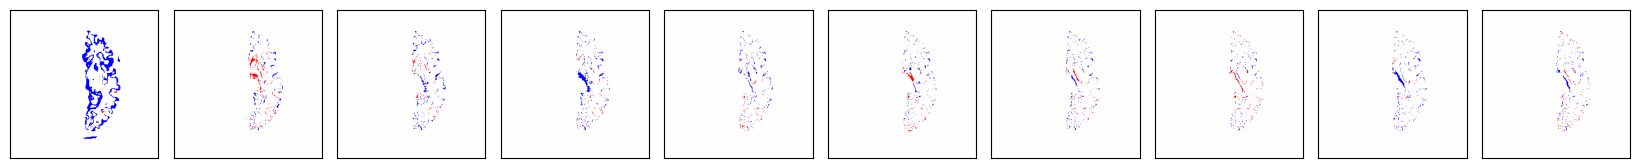

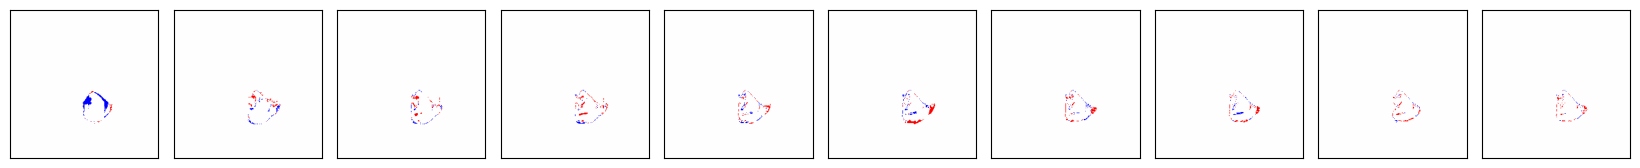

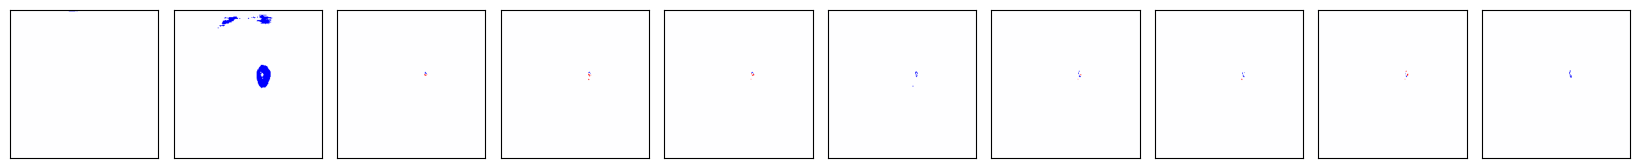

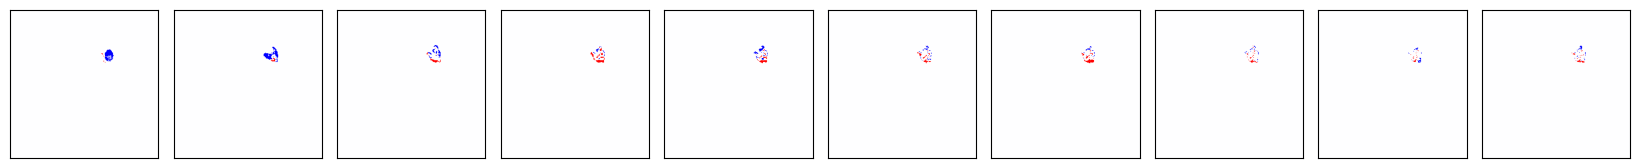

In [16]:
for label in [1,5,18,58]:
    labels = []
    for frac in [0.1, 0.5, 1, 2.5, 5, 10, 25, 50, 75, 100]:
        labels.append((f'singletask_unet_{label}_{frac}', f'singletask_unprompted_{label}_{frac}'))
    fig = plot_difference_maps_pairwise(subset_dict_gif_paths, labels = labels, slices = [opt_slices[label]], figure=None)
    fig.savefig(f'/gpfs/home/kn2347/figs/subset_analysis_plot_examples_unet_medsam/unet-medsam/unet-medsam_{label}.pdf', dpi=300)

In [42]:
open_gif(subset_dict_gif_paths['groundtruth'], label_converter = label_converter).min()

0

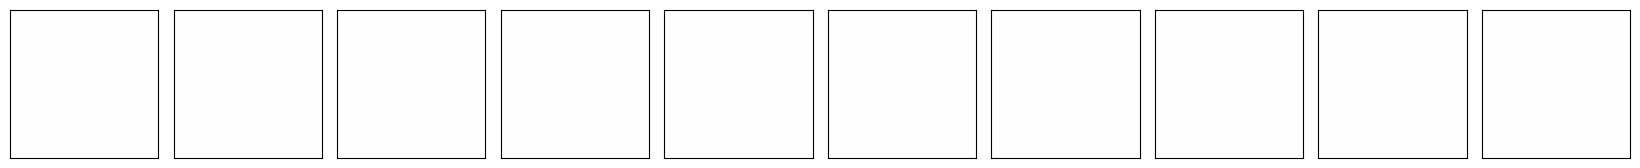

In [45]:
# difference maps but now with ground truth
df_hcp = pd.read_csv('/gpfs/home/kn2347/HCP_MedSAM_project/modified_medsam_repo/hcp_mapping_processed.csv')
df_desired = pd.read_csv('/gpfs/home/kn2347/HCP_MedSAM_project/modified_medsam_repo/darts_name_class_mapping_processed.csv')
NUM_CLASSES = len(df_desired)
label_converter = LabelConverter(df_hcp, df_desired)


for label in [1]:
    labels = []
    for frac in [0.1, 0.5, 1, 2.5, 5, 10, 25, 50, 75, 100]:
        labels.append((f'groundtruth', f'singletask_unprompted_{label}_{frac}'))
    fig = plot_difference_maps_pairwise(subset_dict_gif_paths, labels = labels, slices = [opt_slices[label]], figure=None, pass_single_slice1=True, pass_single_slice2=False, label_converter = label_converter)
    #fig.savefig(f'/gpfs/home/kn2347/figs/subset_analysis_plot_examples_unet_medsam/unet-medsam/unet-medsam_{label}.pdf', dpi=300)
    #fig.savefig(f'/gpfs/home/kn2347/figs/subset_analysis_plot_examples_unet_medsam/unet-medsam/gt-unet_{label}.pdf', dpi=300)


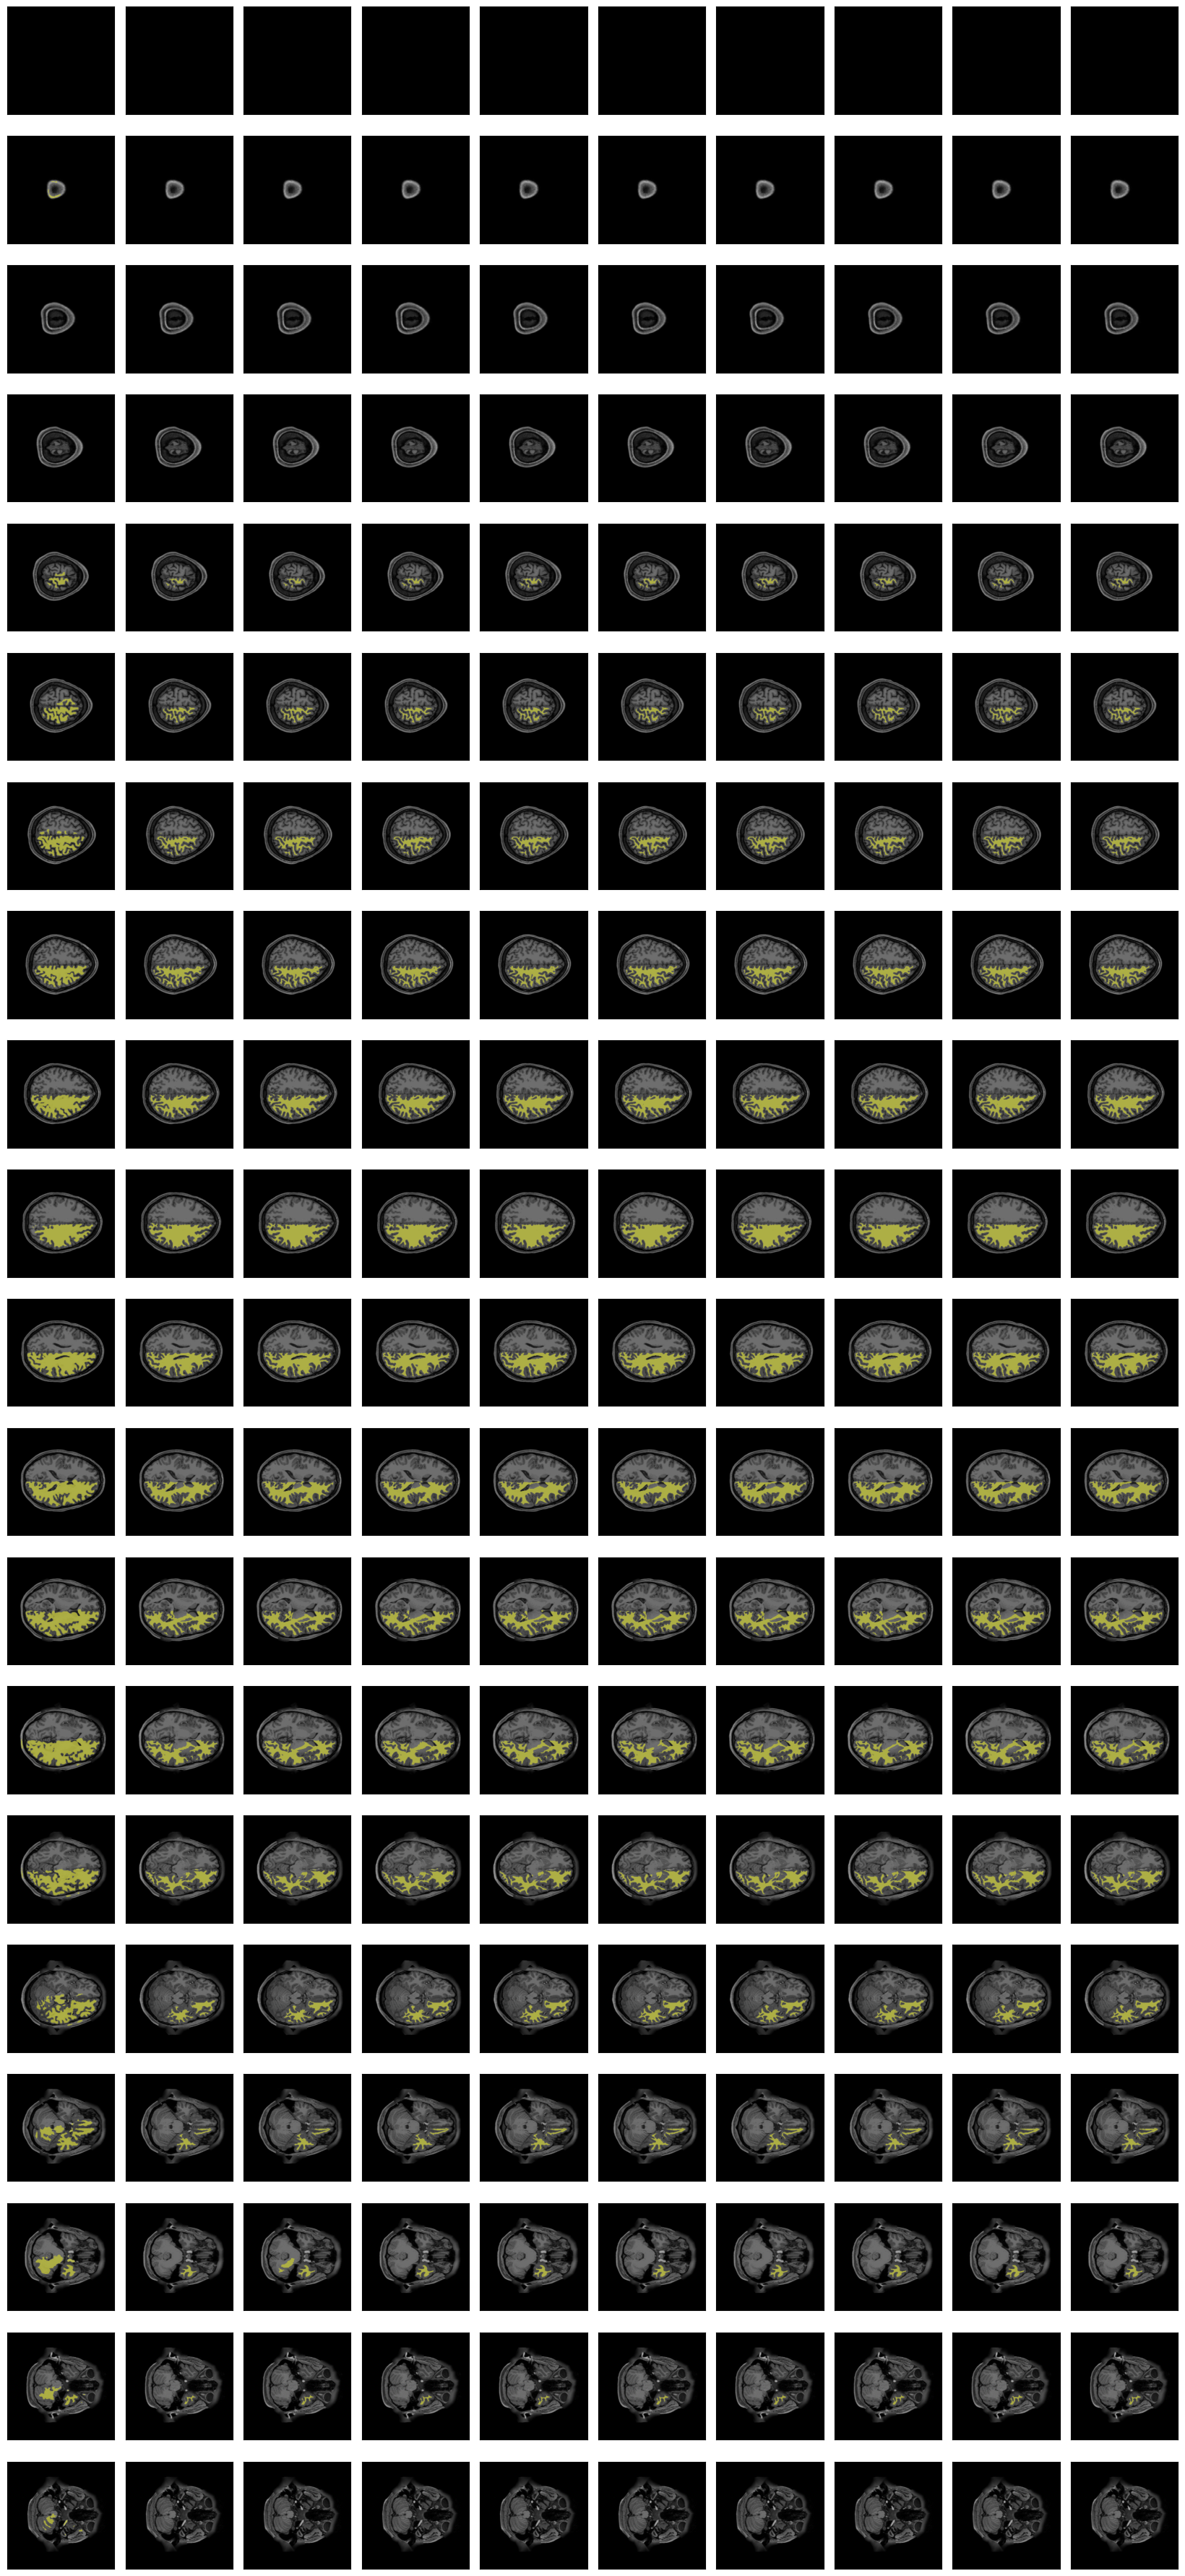

In [11]:

num = 20
slices = np.linspace(0, 152, num = num + 2, dtype=int)
slices = slices[1:-1]
fig =generate_plot(subset_dict_gif_paths, labels = ['singletask_unet_1_0.1', 'singletask_unet_1_0.5', 'singletask_unet_1_1', 'singletask_unet_1_2.5', 'singletask_unet_1_5', 'singletask_unet_1_10', 'singletask_unet_1_25', 'singletask_unet_1_50', 'singletask_unet_1_75', 'singletask_unet_1_100'],
    slices = slices, do_offset = [False] * 10)
#fig.savefig('/gpfs/home/kn2347/figs/registeredbrats_rescale135_medsam_vs_unet.pdf', dpi = 300)


### Difference maps: Subset analysis, Ground truth minus UNet/MedSAM


In [18]:
diff_maps_dict_subset = {}
for model_type in ['singletask_unet', 'singletask_unprompted']:
    for label in [1,5,18,58]:
        for frac in [0.1, 0.5, 1, 2.5, 5, 10, 25, 50, 75, 100]:
            diff_maps_dict_subset[f'{model_type}_{label}_{frac}'] = f'/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/subset_expt_gif_visualizations_10-30-24/segmentations/{model_type}/{label}/{frac}/151425/singletask_seg_all.npy'
            diff_maps_dict_subset[f'gt_{label}'] = '/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/segmentation_slices/151425/seg_101.npy'

/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/subset_expt_gif_visualizations_10-30-24/segmentations/singletask_unet/1/0.1/151425/singletask_seg_all.npy
/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/segmentation_slices/151425/seg_101.npy
/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/subset_expt_gif_visualizations_10-30-24/segmentations/singletask_unet/1/0.5/151425/singletask_seg_all.npy
/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/segmentation_slices/151425/seg_101.npy
/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/subset_expt_gif_visualizations_10-30-24/segmentations/singletask_unet/1/1/151425/singletask_seg_all.npy
/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/segmentation_slices/151425/seg_101.npy
/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/subset_expt_gif_visualizations_10-30-24/segmentations/singletask_unet/1/2.5/151425/singletask_seg_all.npy
/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_n

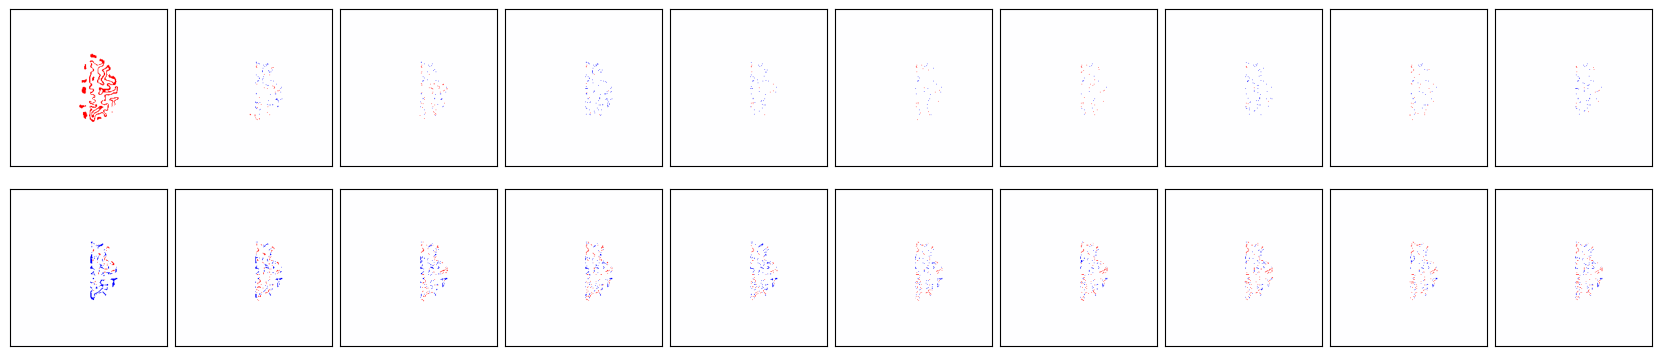

In [28]:
def loader(path):
    listo = glob(path)
    print(listo[0])
    return np.load(listo[0])

fig, axs = plt.subplots(2, 10, constrained_layout=True, figsize=(3.3/2*10, 18/10*2))
for j, model_type in enumerate(['singletask_unet', 'singletask_unprompted']):
    for label in [1]:
        for i, frac in enumerate([0.1, 0.5, 1, 2.5, 5, 10, 25, 50, 75, 100]):
            modelpred = loader(diff_maps_dict_subset[f'{model_type}_{label}_{frac}']).astype(int)
            modelpred = modelpred[101,:,:]
            gt = loader(diff_maps_dict_subset[f'gt_{label}'])
            gt = np.vectorize(label_converter.hcp_to_compressed)(gt)
            gt = (gt == label).astype(int)


            diff = gt - modelpred # this is (256,256)
            diff_mag = np.sign(diff) # (256,256)
            # fix rotation before plotting
            diff_mag = np.rot90(diff_mag)
            axs[j,i].imshow(diff_mag, cmap='bwr_r', vmin=-1, vmax=1)

            axs[j, i].set_xticks([])
            axs[j, i].set_yticks([])

